In [1]:
!pip install -q kaggle
!pip install google-colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive/MyDrive/project/kaggle.json




drive/MyDrive/project/kaggle.json


In [3]:
##change to your current directory
!mkdir -p ~/.kaggle
!cp drive/MyDrive/project/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!kaggle competitions download -c predict-student-performance-from-game-play -p /content/drive/My\ Drive/Colab\ Notebooks/

predict-student-performance-from-game-play.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/predict-student-performance-from-game-play.zip

Archive:  /content/drive/My Drive/Colab Notebooks/predict-student-performance-from-game-play.zip
replace jo_wilder/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: jo_wilder/__init__.py   
  inflating: jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: jo_wilder_310/__init__.py  
  inflating: jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: sample_submission.csv   
  inflating: test.csv                

  inflating: train.csv               
  inflating: train_labels.csv        


In [7]:
!pip install tensorflow_addons
!pip install tensorflow_decision_forests
!pip install tensorflow
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import f1_score

In [21]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}
dataset_df = pd.read_csv('train.csv', dtype=dtypes)


In [10]:
labels=pd.read_csv('train_labels.csv')

In [11]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
labels.head(3)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1


In [12]:
# Reference: https://www.kaggle.com/code/mannubhardwaj1022/we-r-xgb-boost-model?scriptVersionId=128450896&cellId=18

CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [18]:

CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINNING = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Define feature engineering function
def feature_engineer_ver2(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        # Compute standard deviation only for certain features
        if c in BINNING:
            tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
            tmp.name = c + '_std'
            dfs.append(tmp)

        # Binning
        if c in BINNING:  # Check if column is in the list of columns to bin
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [22]:
#dataset_df = feature_engineer(dataset_df)
print(dataset_df)
dataset_df = feature_engineer_ver2(dataset_df)

                 session_id  index  elapsed_time      event_name       name  \
0         20090312431273200      0             0  cutscene_click      basic   
1         20090312431273200      1          1323    person_click      basic   
2         20090312431273200      2           831    person_click      basic   
3         20090312431273200      3          1147    person_click      basic   
4         20090312431273200      4          1863    person_click      basic   
...                     ...    ...           ...             ...        ...   
26296941  22100221145014656   1600       5483231  navigate_click  undefined   
26296942  22100221145014656   1601       5485166  navigate_click  undefined   
26296943  22100221145014656   1602       5485917  navigate_click  undefined   
26296944  22100221145014656   1603       5486753  navigate_click  undefined   
26296945  22100221145014656   1604       5487952      checkpoint      basic   

          level  page  room_coor_x  room_coor_y  sc

In [23]:
# Define GroupKFold with 10 splits
gkf = GroupKFold(n_splits=10)

# Select features for the model
features = [c for c in dataset_df.columns if c != 'level_group']

# Get unique session IDs as validation data
valid = dataset_df.index.unique()

# Dictionary to store trained models
models = {}

# DataFrame to store model predictions
out_prediction = pd.DataFrame(data = np.zeros((len(valid), 18)), index = valid)


# Perform cross-validation with GroupKFold

for i, (train_index, test_index) in enumerate(gkf.split(X = dataset_df, groups = dataset_df.index)):
    print(); print()
    print('#' * 40)
    print('#' * 5, ' ' * 10, f'Fold {i+1}', ' ' * 10, '#' * 5)
    print('#' * 40)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.01,
        'max_depth': 4,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

    # Iterate through questions 1 to 18
    for t in range(1, 19):

        # Determine the level group for the current question
        if t >= 0 and t <= 3:
            year_group = '0-4'
        elif t >= 4 and t <= 13:
            year_group = '5-12'
        elif t >= 14 and t <= 22:
            year_group = '13-22'

        # Get the train and validation data for the current question and level group
        x_train = dataset_df.iloc[train_index]
        x_train = x_train.loc[x_train.level_group == year_group]
        train_users = x_train.index.values
        y_train = labels.loc[labels.q == t].set_index('session').loc[train_users]

        x_valid = dataset_df.iloc[test_index]
        x_valid = x_valid.loc[x_valid.level_group == year_group]
        valid_users = x_valid.index.values
        y_valid = labels.loc[labels.q == t].set_index('session').loc[valid_users]

        # Train an XGBoost model for the current question and level group
        model = XGBClassifier(**params)
        model.fit(
            x_train[features].astype('float32'), y_train['correct'],
            eval_set=[(x_valid[features].astype('float32'), y_valid['correct'])],
            verbose=0
        )

        # print out the output
        print(f'Q:{t} (year group: {year_group})(best_num_trees: {model.best_ntree_limit})', end='\n')

        # Store the trained model
        models[f'{year_group}_{t}'] = model

        out_prediction.loc[valid_users, t-1] = model.predict_proba(x_valid[features].astype('float32'))[:, 1]



########################################
#####            Fold 1            #####
########################################
Q:1 (year group: 0-4)(best_num_trees: 642)
Q:2 (year group: 0-4)(best_num_trees: 498)
Q:3 (year group: 0-4)(best_num_trees: 772)
Q:4 (year group: 5-12)(best_num_trees: 545)
Q:5 (year group: 5-12)(best_num_trees: 534)
Q:6 (year group: 5-12)(best_num_trees: 552)
Q:7 (year group: 5-12)(best_num_trees: 313)
Q:8 (year group: 5-12)(best_num_trees: 471)
Q:9 (year group: 5-12)(best_num_trees: 567)
Q:10 (year group: 5-12)(best_num_trees: 671)
Q:11 (year group: 5-12)(best_num_trees: 362)
Q:12 (year group: 5-12)(best_num_trees: 503)
Q:13 (year group: 5-12)(best_num_trees: 432)
Q:14 (year group: 13-22)(best_num_trees: 989)
Q:15 (year group: 13-22)(best_num_trees: 985)
Q:16 (year group: 13-22)(best_num_trees: 430)
Q:17 (year group: 13-22)(best_num_trees: 385)
Q:18 (year group: 13-22)(best_num_trees: 575)


########################################
#####            Fold 2      

In [25]:
# Create a copy of the out_prediction DataFrame
true_table = out_prediction.copy()

# Iterate through the questions (indices 0 to 17)
for i in range(18):
    # Filter the labels DataFrame for the current question and select the corresponding sessions in the validation set
    tmp = labels.loc[labels.q == i + 1].set_index('session').loc[valid]

    # Update the i-th column of the true_table DataFrame with the 'correct' values from tmp
    true_table[i] = tmp.correct.values

In [26]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

# Iterate through a range of thresholds from 0.4 to 0.8 with a step size of 0.01
for threshold in np.arange(0.4, 0.81, 0.01):
    print(f'threshold: {threshold:.02f}, ', end='')

    # Convert the predicted probabilities in out_prediction to binary predictions using the current threshold
    preds = (out_prediction.values.reshape((-1)) > threshold).astype('int')

    # Calculate the macro-average F1 score between the true_table and the binary predictions
    m = f1_score(true_table.values.reshape((-1)), preds, average='macro')

    # Append the F1 score and threshold to the scores and thresholds lists, respectively
    scores.append(m)
    thresholds.append(threshold)

    # Check if the current F1 score is better than the previous best score
    if m > best_score:
        best_score = m
        best_threshold = threshold

threshold: 0.40, threshold: 0.41, threshold: 0.42, threshold: 0.43, threshold: 0.44, threshold: 0.45, threshold: 0.46, threshold: 0.47, threshold: 0.48, threshold: 0.49, threshold: 0.50, threshold: 0.51, threshold: 0.52, threshold: 0.53, threshold: 0.54, threshold: 0.55, threshold: 0.56, threshold: 0.57, threshold: 0.58, threshold: 0.59, threshold: 0.60, threshold: 0.61, threshold: 0.62, threshold: 0.63, threshold: 0.64, threshold: 0.65, threshold: 0.66, threshold: 0.67, threshold: 0.68, threshold: 0.69, threshold: 0.70, threshold: 0.71, threshold: 0.72, threshold: 0.73, threshold: 0.74, threshold: 0.75, threshold: 0.76, threshold: 0.77, threshold: 0.78, threshold: 0.79, threshold: 0.80, 

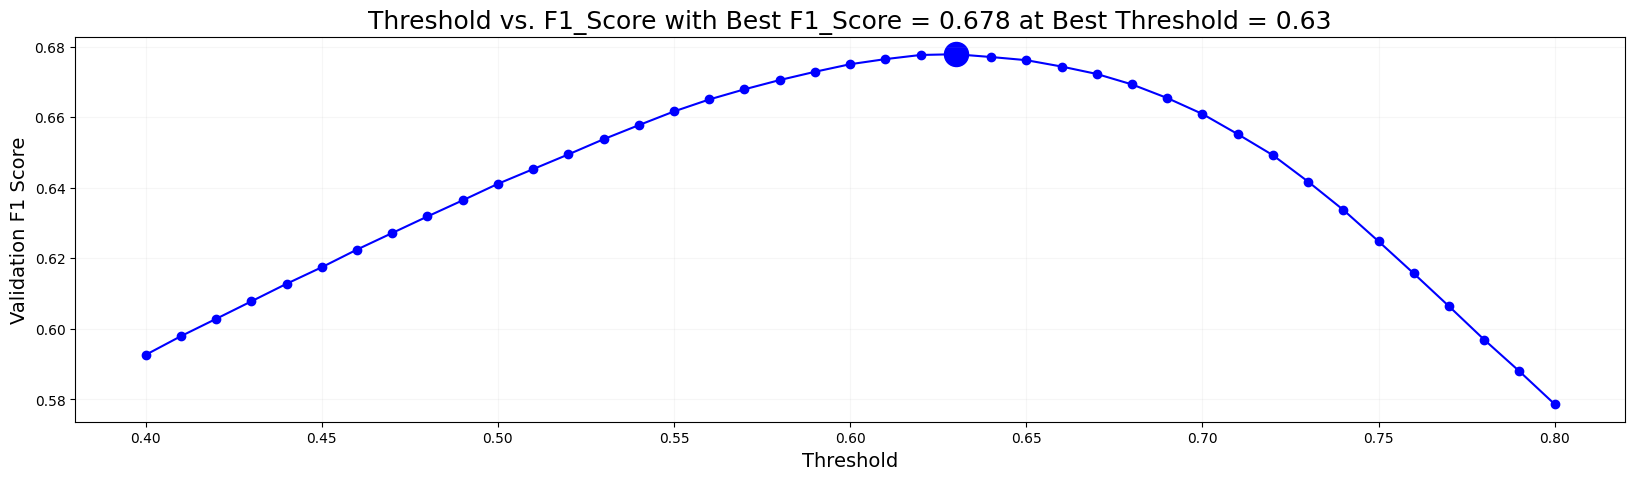

In [27]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize = (20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_score], color = 'blue', s = 300, alpha = 1)
plt.xlabel('Threshold', size = 14)
plt.ylabel('Validation F1 Score', size = 14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.grid(alpha=0.1)
plt.show()

In [28]:
print('When using optimal threshold...')
for k in range(18):

    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true_table[k].values, (out_prediction[k].values > best_threshold).astype('int'), average='macro')
    print(f'Question{k+1}: F1 =',m)

# COMPUTE F1 SCORE OVERALL
m = f1_score(true_table.values.reshape((-1)), (out_prediction.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Question1: F1 = 0.598474335352422
Question2: F1 = 0.49464879356568364
Question3: F1 = 0.4853643645108157
Question4: F1 = 0.6058566270901522
Question5: F1 = 0.5700792398690232
Question6: F1 = 0.6123226017867618
Question7: F1 = 0.5887156334981072
Question8: F1 = 0.5309713020276362
Question9: F1 = 0.6024081232681096
Question10: F1 = 0.5042429964888948
Question11: F1 = 0.5857313830607599
Question12: F1 = 0.4912627872405171
Question13: F1 = 0.431315394085203
Question14: F1 = 0.6047442686242042
Question15: F1 = 0.4982530958927409
Question16: F1 = 0.4643438085952149
Question17: F1 = 0.5465472590400205
Question18: F1 = 0.48733681462140993
==> Overall F1 = 0.6778724658537603


In [29]:
print(out_prediction)

                         0         1         2         3         4         5   \
session_id                                                                      
20090312431273200  0.838651  0.984944  0.957236  0.857945  0.636989  0.862184   
20090312433251036  0.691882  0.978628  0.916733  0.718066  0.418061  0.636452   
20090312455206810  0.766720  0.975628  0.964005  0.776166  0.714346  0.899144   
20090313091715820  0.741885  0.980659  0.955896  0.853300  0.582745  0.837203   
20090313571836404  0.885190  0.992082  0.964188  0.871218  0.743127  0.931865   
...                     ...       ...       ...       ...       ...       ...   
22100215342220508  0.698466  0.982845  0.911407  0.894073  0.647788  0.872315   
22100215460321130  0.675090  0.990139  0.890794  0.772177  0.523328  0.759139   
22100217104993650  0.591350  0.958296  0.895952  0.859688  0.530188  0.807696   
22100219442786200  0.812451  0.986122  0.959595  0.855835  0.667676  0.876938   
22100221145014656  0.511513 

In [30]:
print(true_table)

                   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  \
session_id                                                                      
20090312431273200   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1   
20090312433251036   0   1   1   1   0   1   1   0   1   0   0   1   0   1   0   
20090312455206810   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   
20090313091715820   0   1   1   1   1   0   1   1   1   0   0   1   0   1   0   
20090313571836404   1   1   1   1   1   1   1   1   1   1   1   0   1   0   1   
...                ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
22100215342220508   1   1   1   1   1   1   1   0   1   1   1   1   0   1   1   
22100215460321130   0   1   1   1   0   1   1   0   1   0   1   1   0   1   0   
22100217104993650   1   1   1   1   1   1   1   1   1   0   1   1   1   1   0   
22100219442786200   0   1   1   1   1   1   1   0   1   0   1   1   0   1   0   
22100221145014656   0   1   